In [0]:
# Устанавливаем tensorflow

In [0]:
#Если из тетрадки и tf не установлен
#!pip install tensorflow==2.0

In [3]:
#Если из colab
!pip install tensorflow

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow import keras



In [0]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

# Загрузим данные

MNIST - объёмная база данных образцов рукописного написания цифр.
Cодержит 60000 изображений для обучения и 10000 изображений для тестирования


In [0]:
mnist = tf.keras.datasets.mnist

(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = mnist.load_data()
x_train_mnist, x_test_mnist = x_train_mnist / 255.0, x_test_mnist / 255.0

Посмотрим как выглядят наши данные

In [7]:

print(x_train_mnist.shape)
print(x_test_mnist.shape)
print (y_train_mnist[:10])
print (y_test_mnist[:10])

(60000, 28, 28)
(10000, 28, 28)
[5 0 4 1 9 2 1 3 1 4]
[7 2 1 0 4 1 4 9 5 9]


Пример кусочка картинки (пиксели со значениями от 0 до 255):


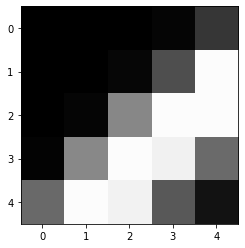

Пример картинки:


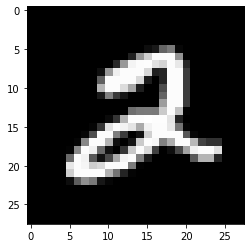

y_train [shape (60000,)] 10 примеров:
 [5 0 4 1 9 2 1 3 1 4]


In [8]:
x_train_mnist_image = np.tile(x_train_mnist[5, :, :].reshape((28, 28))[:, :, np.newaxis], (1, 1, 3))
print("Пример кусочка картинки (пиксели со значениями от 0 до 255):")
plt.imshow(x_train_mnist_image[15:20, 5:10], cmap="Greys")
plt.show()
print("Пример картинки:")
plt.imshow(x_train_mnist_image, cmap="Greys")
plt.show()
print("y_train [shape %s] 10 примеров:\n" % (str(y_train_mnist.shape)), y_train_mnist[:10])

# Градиентный бустинг

Попробуем начать с одного из самых популярных методов машинного обучения 


<img src="https://www.researchgate.net/profile/Maria_Peraita-Adrados/publication/326379229/figure/fig5/AS:647978477948928@1531501516288/A-simple-example-of-visualizing-gradient-boosting_W640.jpg" width="300">

Над деревьями делают бустинг и это алгоритм №1 на Kaggle! Проверим в нашей задаче!

In [9]:
x_train_mnist_flat = x_train_mnist.reshape(-1, 28*28).astype(float)
print(x_train_mnist_flat.shape)

x_test_mnist_flat = x_test_mnist.reshape(-1, 28*28).astype(float)
print(x_test_mnist_flat.shape)

(60000, 784)
(10000, 784)


In [10]:
# Очень долго работает (потому что алгоритм переборный)!
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(learning_rate=0.3, n_estimators=10, verbose=1, subsample=0.5)
clf.fit(x_train_mnist_flat, y_train_mnist)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1       40219.2341       28484.3185            2.61m
         2       31043.2129        9078.3657            2.30m
         3       25375.3249        5565.6472            2.02m
         4       21820.7030        3658.9004            1.73m
         5       19091.1155        2769.1724            1.44m
         6       16593.5382        2100.4585            1.15m
         7       15367.9819        1261.7844           51.92s
         8       13988.6618        1252.3175           34.63s
         9       13090.5459         782.5608           17.32s
        10       12074.1659         747.2300            0.00s


GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.3, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=10,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=0.5, tol=0.0001,
                           validation_fraction=0.1, verbose=1,
                           warm_start=False)

In [11]:
# Качество так себе, а если картинка будет 300x300 это будет еще и вечность работать!
from sklearn.metrics import accuracy_score
accuracy_score(y_test_mnist, clf.predict(x_test_mnist_flat))

0.8941

# Собираем модель

Соберем сложную функцию как комбинацию простых линейных моделей (например, логистических регрессий)

Для оптимизации всех параметров нам не нужен перебор, мы можем честно посчитать производную потерь по каждому параметру и чуточку их подвинуть! Это работает очень быстро!


## Описание используемых слоев

*Flatten*  - трансформирует матрицу в вектор единичной размерности (https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten)

*Dense*  - линейная операция, в которой каждый вход связан с каждым выходом с помощью веса (таким образом, есть веса n_inputs * n_outputs - которые могут быть много!). Обычно сопровождается нелинейной функцией активации. (https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)

<img src="https://cdn-images-1.medium.com/max/1600/1*Gh5PS4R_A5drl5ebd_gNrg@2x.png" width="350">

*Dropout* - за одну итерацию обучения проходит по всем нейронам определенного слоя и с вероятностью p полностью исключает их из сети на время итерации. Это заставит сеть обрабатывать ошибки и не полагаться на существование определенного нейрона (или группы нейронов), а полагаться на “единое мнение” (consensus) нейронов внутри одного слоя. Это довольно простой метод, который эффективно борется с проблемой переобучения сам, без необходимости вводить другие регуляризаторы. Схема ниже иллюстрирует данный метод. (https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout)
<img src="https://hsto.org/files/5d9/30f/772/5d930f7729434bf8947e14d740a74d99.png" width="700">


In [0]:
model_mnist = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

In [13]:
model_mnist.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


In [0]:
model_mnist.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Обучаем и оцениваем модель:

In [15]:
model_mnist.fit(x_train_mnist, 
          y_train_mnist,
          batch_size=64,
          epochs=5)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 4s 60us/sample - loss: 0.3356 - accuracy: 0.9044
Epoch 2/5
60000/60000 [==============================] - 3s 55us/sample - loss: 0.1650 - accuracy: 0.9522
Epoch 3/5
60000/60000 [==============================] - 3s 54us/sample - loss: 0.1244 - accuracy: 0.9628
Epoch 4/5
60000/60000 [==============================] - 3s 52us/sample - loss: 0.1013 - accuracy: 0.9697
Epoch 5/5
60000/60000 [==============================] - 3s 50us/sample - loss: 0.0866 - accuracy: 0.9740


In [16]:
# Вот тут точность уже поинтереснее
model_mnist.evaluate(x_test_mnist,  y_test_mnist, verbose=2)

10000/1 - 1s - loss: 0.0386 - accuracy: 0.9758


[0.07511638466399163, 0.9758]

# Попробуем более сложную задачу

Fashion MNIST: На каждом изображении содержится по одному предмету одежды в низком разрешении (28 на 28 пикселей)

Содержит 70,000 монохромных изображений в 10 категориях.

Загрузим данные

Категории:
```
0 T-shirt/top 
1 Trouser 
2 Pullover 
3 Dress 
4 Coat 
5 Sandal 
6 Shirt 
7 Sneaker 
8 Bag 
9 Ankle boot
```

In [0]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(x_train_fashion, y_train_fashion), (x_test_fashion, y_test_fashion) = fashion_mnist.load_data()
x_train_fashion, x_test_fashion = x_train_fashion / 255.0, x_test_fashion / 255.0

In [18]:
print(x_train_fashion.shape)
print(x_test_fashion.shape)
print (y_train_fashion[:10])
print (y_test_fashion[:10])

(60000, 28, 28)
(10000, 28, 28)
[9 0 0 3 0 2 7 2 5 5]
[9 2 1 1 6 1 4 6 5 7]


Пример кусочка картинки (пиксели со значениями от 0 до 255):


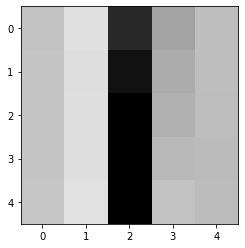

Пример картинки:


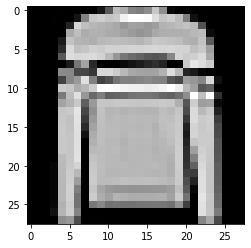

y_train [shape (60000,)] 10 примеров:
 [9 0 0 3 0 2 7 2 5 5]


In [19]:
x_train_fashion_image = np.tile(x_train_fashion[5, :, :].reshape((28, 28))[:, :, np.newaxis], (1, 1, 3))
print("Пример кусочка картинки (пиксели со значениями от 0 до 255):")
plt.imshow(x_train_fashion_image[15:20, 5:10], cmap="Greys")
plt.show()
print("Пример картинки:")
plt.imshow(x_train_fashion_image, cmap="Greys")
plt.show()
print("y_train [shape %s] 10 примеров:\n" % (str(y_train_fashion.shape)), y_train_fashion[:10])

Собираем модель

In [0]:
model_fm = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

In [0]:
model_fm.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Обучаем и оцениваем модель:

In [22]:
model_fm.fit(x_train_fashion,
          y_train_fashion,
          batch_size=64,
          epochs=5)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 3s 56us/sample - loss: 0.5579 - accuracy: 0.8053
Epoch 2/5
60000/60000 [==============================] - 3s 50us/sample - loss: 0.4055 - accuracy: 0.8540
Epoch 3/5
60000/60000 [==============================] - 3s 50us/sample - loss: 0.3704 - accuracy: 0.8658
Epoch 4/5
60000/60000 [==============================] - 3s 50us/sample - loss: 0.3461 - accuracy: 0.8728
Epoch 5/5
60000/60000 [==============================] - 3s 52us/sample - loss: 0.3332 - accuracy: 0.8781


In [23]:
# Качество уже не такое хорошее
model_fm.evaluate(x_test_fashion,  y_test_fashion, verbose=2)

10000/1 - 1s - loss: 0.2901 - accuracy: 0.8683


[0.3604362168312073, 0.8683]

#Попробуем собрать простую сверточную сеть.

Новые слои:

*Conv2D* <br>
Пусть на вход подается изображение, которое состоит из 0 и 1 (так нам будет удобнее устно считать и понимать, как именно работает свёртка) и пусть имеется скользящее окно фиксированного размера (в нашем случае 2 × 2). Нашим окошком 2 × 2 мы пробегаем по изображению и каждый кусочек, по которому пробегает окошко, поэлементно умножаем на некоторые веса и складываем. То есть получаем скалярное произведение нашего кусочка изображения и фильтра, состоящего из весов, которые мы будем обучать. (https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)
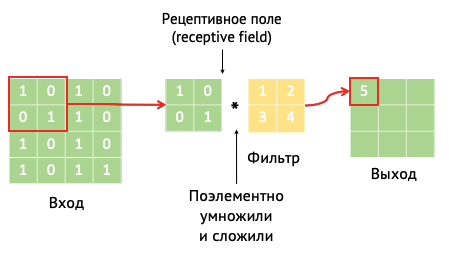

*MaxPool2D*
  Процесс дискретизации на основе выборки . Цель состоит в том, чтобы уменьшить выборку входного представления (изображения, выходной матрицы скрытого слоя и т. Д.), Уменьшив его размерность и сделав допущения относительно предположений о свойствах, содержащихся в выбранных субрегионах.
  Это делается для того, чтобы частично помочь в адаптации, предоставляя абстрактную форму представления. Кроме того, он уменьшает вычислительные затраты за счет уменьшения количества изучаемых параметров и обеспечивает базовую неизменность перевода для внутреннего представления.
(https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D)
<img src="https://computersciencewiki.org/images/8/8a/MaxpoolSample2.png" width="500">

In [0]:
model_conv = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(16, kernel_size=3, strides=1, padding='same', input_shape=(28, 28,1)),
  tf.keras.layers.MaxPool2D(),
  tf.keras.layers.Conv2D(32, kernel_size=3, strides=1, padding='same'),
  tf.keras.layers.MaxPool2D(),
  tf.keras.layers.Conv2D(64, kernel_size=3, strides=1, padding='same'),
  tf.keras.layers.MaxPool2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(10, activation='softmax')
])

In [0]:
model_conv.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [26]:
model_conv.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 576)              

In [31]:
# Точность уже получше
model_conv.fit(x_train_fashion[:, :, :, np.newaxis],
          y_train_fashion,
          batch_size=64,
          epochs=5)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 45s 746us/sample - loss: 0.1874 - accuracy: 0.9325
Epoch 2/5
60000/60000 [==============================] - 45s 748us/sample - loss: 0.1780 - accuracy: 0.9363
Epoch 3/5
60000/60000 [==============================] - 46s 762us/sample - loss: 0.1713 - accuracy: 0.9379
Epoch 4/5
60000/60000 [==============================] - 45s 750us/sample - loss: 0.1600 - accuracy: 0.9417
Epoch 5/5
60000/60000 [==============================] - 45s 751us/sample - loss: 0.1523 - accuracy: 0.9454
